In [ ]:
import torch

In [ ]:
from torchvision import datasets

In [ ]:
download_dir = "./dataset"

# Скачиваем обучающую выборку.
train_data = datasets.CIFAR10(root=download_dir, download=True, train=True)

# Скачиваем валидационную выборку.
val_data = datasets.CIFAR10(root=download_dir, download=True, train=False)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [ ]:
# Объекты данных из обучающей выборки (50 000 цветных картинок размера 32 x 32).
x_train = torch.tensor(train_data.data)
x_train.shape

torch.Size([50000, 32, 32, 3])

In [ ]:
# Предсказываемые величины для обучающей выборки (50 000 чисел от 0 до 9).
y_train = torch.tensor(train_data.targets)

print(y_train.shape, y_train.min(), y_train.max(), sep="\n")

torch.Size([50000])
tensor(0)
tensor(9)


In [ ]:
# Сопоставление численных значений
#  (индексов в списке classes) реальным классам.
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# Названия классов на русском языке.
classes_ru = [
    "самолёт",
    "машина",
    "птица",
    "кошка",
    "олень",
    "собака",
    "лягушка",
    "лошадь",
    "корабль",
    "грузовик",
]

In [ ]:
# Аналогично записываем x и y для валидационной выборки (10 000 примеров).
x_val = torch.tensor(val_data.data)
y_val = torch.tensor(val_data.targets)

print(x_val.shape, y_val.shape, sep="\n")

torch.Size([10000, 32, 32, 3])
torch.Size([10000])


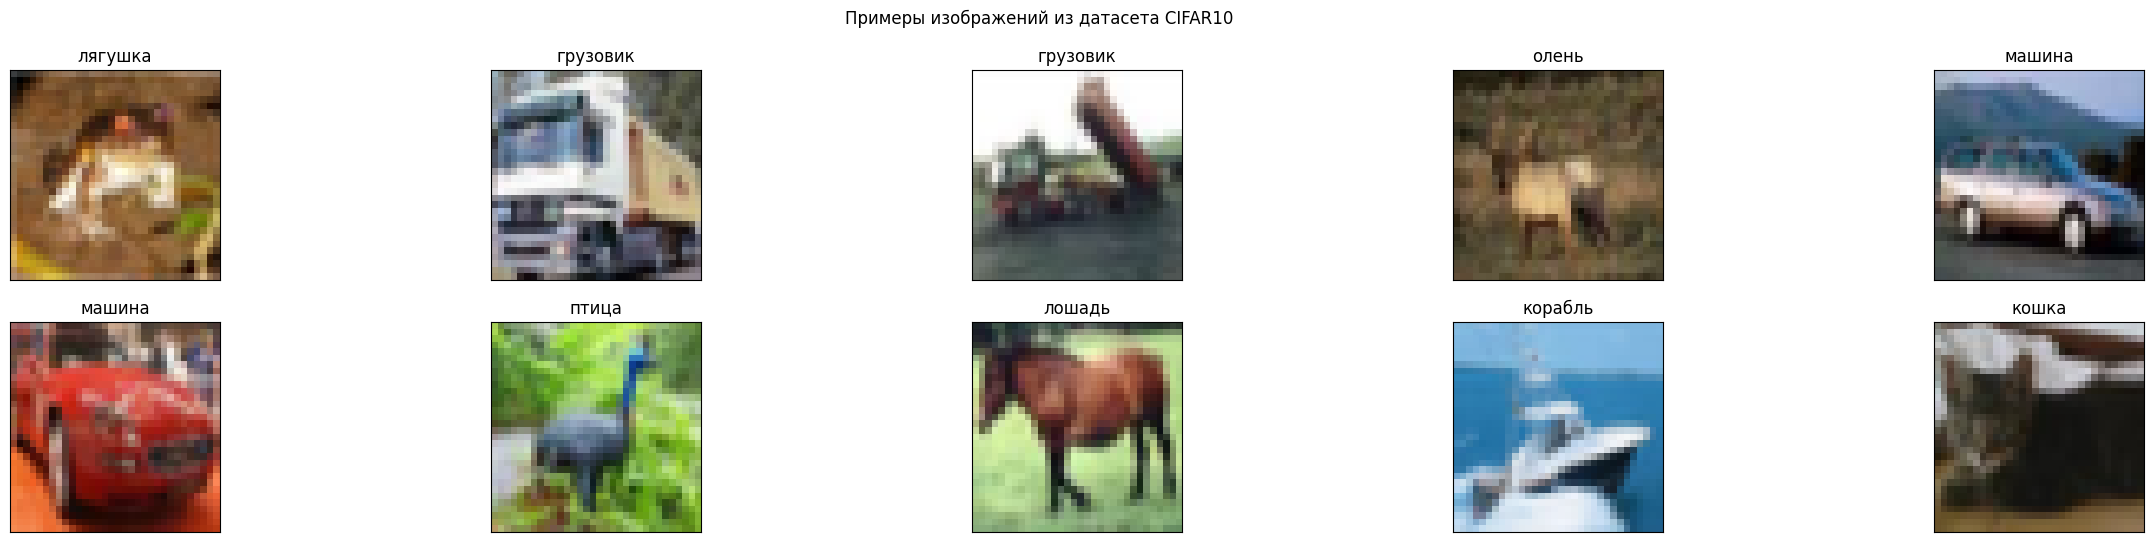

In [ ]:
# Посмотрим на то, как выглядят картинки из датасета.

import matplotlib.pyplot as plt
%matplotlib inline

hh = 2
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(30, 3 * hh))
fig.suptitle("Примеры изображений из датасета CIFAR10")

for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.title(classes_ru[y])
plt.show()

In [ ]:
# При обучении нейросетей нам будет удобнее работать
#  с пикселями, представленными в виде вещественных чисел.
x_train = torch.tensor(train_data.data) / 255.
x_val = torch.tensor(val_data.data) / 255.

print(x_train.min(), x_train.max(), x_train.dtype, sep="\n")

tensor(0.)
tensor(1.)
torch.float32


In [ ]:
# Свёртка.
conv_layer = torch.nn.Conv2d(
    in_channels=3,         # Число каналов на входе.
    out_channels=10,       # Число каналов на выходе.
    kernel_size=3,         # Размер ядра.
    padding=1,             # Размер паддинга (1 элемент добавляется с каждой стороны).
    padding_mode="zeros",  # Указываем, что в паддинге проставляем нули вдоль границ входного тензора.
    stride=1,              # Stride - 1 (смотрим на каждую позицию).
    dilation=1,            # Dilation - 1 (ядро прикладывается к фрагменту изображения без пропусков).
)

# Применяется слой свёртки к группе картинок в формате bs x c x h x w.
x = torch.rand(2, 3, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x = conv_layer(x)

print(f"Размер после свёртки: {x.shape}")

Размер до свёртки: torch.Size([2, 3, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])


In [ ]:
# Residual connection.
conv_layer_2 = torch.nn.Conv2d(
    in_channels=10,
    out_channels=10,
    kernel_size=3,
    padding=1,
)

x = torch.rand(2, 10, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x2 = conv_layer_2(x)

print(f"Размер после свёртки: {x2.shape}")

h = x + x2

Размер до свёртки: torch.Size([2, 10, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])


In [ ]:
# Residual connection в ситуации, когда вход и выход
#  имеют разные количества каналов.
x = torch.rand(2, 3, 32, 32)

print(f"Размер до свёртки: {x.shape}")

x2 = conv_layer(x)

print(f"Размер после свёртки: {x2.shape}")

# Вариант 1: объединяем (конкатенируем) тензоры вдоль размерности каналов.
h = torch.cat([x, x2], dim=1)

print(f"Размер выхода при конкатенации: {h.shape}")


# Вариант 2: применяем свёртку с ядром 1x1, чтобы привести
#  исходный тензор к состоянию, когда число каналов
#  в нём совпадает с числом каналов в выходном тензоре.
conv_1_1 = torch.nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=1,  # Ищем шаблоны размера 1x1xc
)
h = conv_1_1(x) + x2

print(f"Размер выхода при сумме через 1x1 свёртку: {h.shape}")

Размер до свёртки: torch.Size([2, 3, 32, 32])
Размер после свёртки: torch.Size([2, 10, 32, 32])
Размер выхода при конкатенации: torch.Size([2, 13, 32, 32])
Размер выхода при сумме через 1x1 свёртку: torch.Size([2, 10, 32, 32])


In [ ]:
# Напишем свой блок свёртки с residual connection.

class ResidualBlock(torch.nn.Module):
    # Инициализация блока.
    def __init__(
        self,
        input_c,                   # Число каналов на входе.
        output_c,                  # Число каналов на выходе.
        kernel_size,               # Размер ядра.
        activation=torch.nn.ReLU,  # Класс функции активации.
    ):
        super().__init__()

        # Функция активации для нелинейности.
        self.activation = activation()

        # TODO:
        # Паддинг подбираем такой, чтобы размеры h и w не менялись
        #  (считаем, что размер ядра всегда нечётный).
        padding_size = ...

        # TODO:
        # Операция свёртки.
        # Создайте сверточный слой с помощью класса torch.nn.Conv2d
        # укажите количество каналов на входе и выходе, размер ядра,
        # размер паддинга и режим его выполнения (заполнение нулями)
        self.conv = ...

        # Если числа каналов у входа и выхода различаются,
        if input_c != output_c:
            # ТОDO:
            # то будем делать свёртку с ядром размера 1.
            self.correct_channels = ...
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход.

    # Прямой проход.
    def forward(self, x):
        # ТОDO:
        # реализуйте прямой проход
        return ...

In [ ]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 3 канала на входе, 10 каналов на выходе,
# размер ядра свертки равен 3 и
# в качестве функции активации используется ReLU



In [ ]:
# TODO:
# Создайте экземпляр класса ResidualBlock() у которого 10 каналов на входе, 10 каналов на выходе и
# размер ядра свертки равен 3 и
# в качестве функции активации используется "Гиперболический тангенс"


In [ ]:
# Соберём вручную простую свёрточную нейросеть,
#  используя написанный ранее residual block.
from collections import OrderedDict

conv_layers = [
    (
        "residual_block_1",
        # TODO:
        # Создайте экземпляр класса ResidualBlock() у которого 3 канала на входе, 8 каналов на выходе,
        # размер ядра свертки равен 3 и
        # в качестве функции активации используется ReLU

    ),
    (
        "residual_block_2",
        # TODO:
        # Создайте экземпляр класса ResidualBlock() у которого 8 каналов на входе, 16 каналов на выходе,
        # размер ядра свертки равен 3 и
        # в качестве функции активации используется ReLU

    ),
    (
        "pooling",
        torch.nn.MaxPool2d(kernel_size=2),
    ),
    (
        "residual_block_3",
        # TODO:
        # Создайте экземпляр класса ResidualBlock() у которого 16 каналов на входе, 32 канала на выходе,
        # размер ядра свертки равен 3 и
        # в качестве функции активации используется ReLU

    ),
]

conv_model = torch.nn.Sequential(OrderedDict(conv_layers))
conv_model

Sequential(
  (residual_block_1): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
  )
  (residual_block_2): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (residual_block_3): ResidualBlock(
    (activation): ReLU()
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (correct_channels): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [ ]:
# С помощью функции max в torch можно сделать MaxPooling.
h = torch.rand(2, 3)

print(h, h.max(1), h.max(1).values.shape, h[0, :], h[1, :], sep="\n\n")

tensor([[0.2511, 0.8082, 0.5617],
        [0.9545, 0.1351, 0.4551]])

torch.return_types.max(
values=tensor([0.8082, 0.9545]),
indices=tensor([1, 0]))

torch.Size([2])

tensor([0.2511, 0.8082, 0.5617])

tensor([0.9545, 0.1351, 0.4551])


In [ ]:
# Теперь соберём вручную классификатор.
lin_layers = [
    (
        "linear_1",
        # TODO:
        # Сделайте полносвязный слой у которого 32 канала на входе, 16 каналов на выходе,
        # создайте для этого экземпляр класса torch.nn.Linear

    ),
    (
        "linear_activation_1",
        # TODO:
        # в качестве функции активации используется ReLU

    ),
    (
        "linear_2",
        # TODO:
        # Сделайте полносвязный слой у которого 16 каналов на входе, 10 каналов на выходе,
        # создайте для этого экземпляр класса torch.nn.Linear

    ),
    (
        "softmax",
        torch.nn.Softmax(-1),
    ),
]

lin_model = torch.nn.Sequential(OrderedDict(lin_layers))
lin_model

Sequential(
  (linear_1): Linear(in_features=32, out_features=16, bias=True)
  (linear_activation_1): ReLU()
  (linear_2): Linear(in_features=16, out_features=10, bias=True)
  (softmax): Softmax(dim=-1)
)

In [ ]:
# Посмотрим на примере.
x = torch.rand(2, 3, 32, 32)

print(f"Изначальный размер: {x.shape}")

# Применяем свёрточные слои.
x = conv_model(x)

print(f"После свёрток: {x.shape}")

# Сделаем операцию GlobalMaxPooling.
x = x.max(-1).values.max(-1).values

print(f"После глобального пулинга: {x.shape}")

# Применяем классификатор.
x = lin_model(x)

print(f"После классификатора: {x.shape}\n")

print(x, x.sum(1), sep="\n\n")

Изначальный размер: torch.Size([2, 3, 32, 32])
После свёрток: torch.Size([2, 32, 16, 16])
После глобального пулинга: torch.Size([2, 32])
После классификатора: torch.Size([2, 10])

tensor([[0.1017, 0.0921, 0.0988, 0.0746, 0.0834, 0.1188, 0.1246, 0.1066, 0.1112,
         0.0882],
        [0.1026, 0.0919, 0.0990, 0.0735, 0.0833, 0.1188, 0.1251, 0.1074, 0.1120,
         0.0863]], grad_fn=<SoftmaxBackward0>)

tensor([1., 1.], grad_fn=<SumBackward1>)


In [ ]:
# Повторим задание свёрточной нейронной сети на основе residual block,
# но в более общем виде при помощи обёртки torch.nn.Module.
IMG_SIZE = 32

class ResidualModel(torch.nn.Module):
    def __init__(
        self,
        out_size,                    # Число классов.
        residual_sizes,              # Задаём список троек: количество residual-блоков,
                                     #  число каналов и размер ядра в каждом таком блоке.
        linear_sizes,                # Список размеров линейных слоёв в финальном классификаторе.
        activation = torch.nn.ReLU,  # Какую функцию активации использовать.
        flatten = True,              # Использовать Flatten или GlobalPooling.
    ):
        super().__init__()
        self.flatten = flatten

        # Собираем все свёрточные слои в один блок.
        conv_layers = []

        current_c = 3
        for group_index, (num_residual, out_channels, kernel_size) in enumerate(residual_sizes):
            for residual_index in range(num_residual):
                conv_layers.append((
                    # Добавляем несколько residual-блоков для каждой группы.
                    f"residual_{group_index}_{residual_index}",
                    ResidualBlock(
                        input_c = current_c if residual_index == 0 else out_channels,
                        output_c = out_channels,
                        kernel_size = kernel_size,
                        activation = activation,
                    ),
                ))
            current_c = out_channels
            if group_index < len(residual_sizes) - 1:
                conv_layers.append((
                    # В конце группы добавляем один pooling-слой,
                    # если это не последняя группа.
                    f"pooling_{group_index}",
                    torch.nn.AvgPool2d(2),
                ))

        self.conv_part = torch.nn.Sequential(OrderedDict(conv_layers))

        # Собираем все линейные слои во второй блок.
        out_c = residual_sizes[-1][1]
        final_size = IMG_SIZE // 2 ** (len(residual_sizes) - 1)
        clf_in_size = (out_c * final_size**2) if flatten else out_c

        linear_sizes = [clf_in_size, *linear_sizes, out_size]

        clf_layers = []

        for i, (from_size, to_size) in enumerate(zip(linear_sizes[:-1], linear_sizes[1:])):
            clf_layers.append((f"linear_{i}", torch.nn.Linear(from_size, to_size)))
            if i < len(linear_sizes) - 2:
                clf_layers.append((f"act_{i}", activation()))
            else:
                clf_layers.append(("log_softmax", torch.nn.LogSoftmax(-1)))

        self.clf_part = torch.nn.Sequential(OrderedDict(clf_layers))

    def forward(self, x):  # input (bs x h x w x c_in)
        x = x.permute((0, 3, 1, 2))  # (bs x c_in x h x w)

        x = self.conv_part(x)  # bs x c_out x h' x w'

        if self.flatten:
            # Операция Flatten.
            x = x.reshape(x.shape[0], -1)  # bs x (c_out * h' * w')
        else:
            # Операция GlobalMaxPooling.
            x = x.max(-1).values.max(-1).values  # bs x c_out


        x = self.clf_part(x)  # bs x 10

        return x




In [ ]:
def print_num_params(model):
    # Считаем общее количество обучаемых весов в модели.
    sum_params_size = 0
    for name, param in model.named_parameters():
        param_size = param.numel()
        print("{:<46} ~ {:<14} ~ {}".format(name, str(list(param.shape)), param_size))
        sum_params_size += param_size
    print(f"Общее число параметров ~ {sum_params_size}")


In [ ]:
model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=torch.nn.ReLU,
    flatten=True,
)

model

ResidualModel(
  (conv_part): Sequential(
    (residual_0_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_0_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_1_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_1_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_2_0): Re

In [ ]:
print_num_params(model)

conv_part.residual_0_0.conv.weight             ~ [8, 3, 3, 3]   ~ 216
conv_part.residual_0_0.conv.bias               ~ [8]            ~ 8
conv_part.residual_0_0.correct_channels.weight ~ [8, 3, 1, 1]   ~ 24
conv_part.residual_0_0.correct_channels.bias   ~ [8]            ~ 8
conv_part.residual_0_1.conv.weight             ~ [8, 8, 3, 3]   ~ 576
conv_part.residual_0_1.conv.bias               ~ [8]            ~ 8
conv_part.residual_1_0.conv.weight             ~ [16, 8, 3, 3]  ~ 1152
conv_part.residual_1_0.conv.bias               ~ [16]           ~ 16
conv_part.residual_1_0.correct_channels.weight ~ [16, 8, 1, 1]  ~ 128
conv_part.residual_1_0.correct_channels.bias   ~ [16]           ~ 16
conv_part.residual_1_1.conv.weight             ~ [16, 16, 3, 3] ~ 2304
conv_part.residual_1_1.conv.bias               ~ [16]           ~ 16
conv_part.residual_2_0.conv.weight             ~ [32, 16, 3, 3] ~ 4608
conv_part.residual_2_0.conv.bias               ~ [32]           ~ 32
conv_part.residual_2_0.corre

In [ ]:
# TODO:
# Используя созданный ранее класс ResidualModel,
# создайте нейронную сеть с такой же архитектурой как и ранее,
# но использующую глобальный MaxPooling перед применением полносвязных слоев

model

ResidualModel(
  (conv_part): Sequential(
    (residual_0_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_0_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_1_0): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_1_1): ResidualBlock(
      (activation): ReLU()
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_2_0): Re

In [ ]:
# TODO:
# выведите подробную информацию о коичечестве параметров этой неросети


conv_part.residual_0_0.conv.weight             ~ [8, 3, 3, 3]   ~ 216
conv_part.residual_0_0.conv.bias               ~ [8]            ~ 8
conv_part.residual_0_0.correct_channels.weight ~ [8, 3, 1, 1]   ~ 24
conv_part.residual_0_0.correct_channels.bias   ~ [8]            ~ 8
conv_part.residual_0_1.conv.weight             ~ [8, 8, 3, 3]   ~ 576
conv_part.residual_0_1.conv.bias               ~ [8]            ~ 8
conv_part.residual_1_0.conv.weight             ~ [16, 8, 3, 3]  ~ 1152
conv_part.residual_1_0.conv.bias               ~ [16]           ~ 16
conv_part.residual_1_0.correct_channels.weight ~ [16, 8, 1, 1]  ~ 128
conv_part.residual_1_0.correct_channels.bias   ~ [16]           ~ 16
conv_part.residual_1_1.conv.weight             ~ [16, 16, 3, 3] ~ 2304
conv_part.residual_1_1.conv.bias               ~ [16]           ~ 16
conv_part.residual_2_0.conv.weight             ~ [32, 16, 3, 3] ~ 4608
conv_part.residual_2_0.conv.bias               ~ [32]           ~ 32
conv_part.residual_2_0.corre

In [ ]:
import matplotlib.pyplot as plt

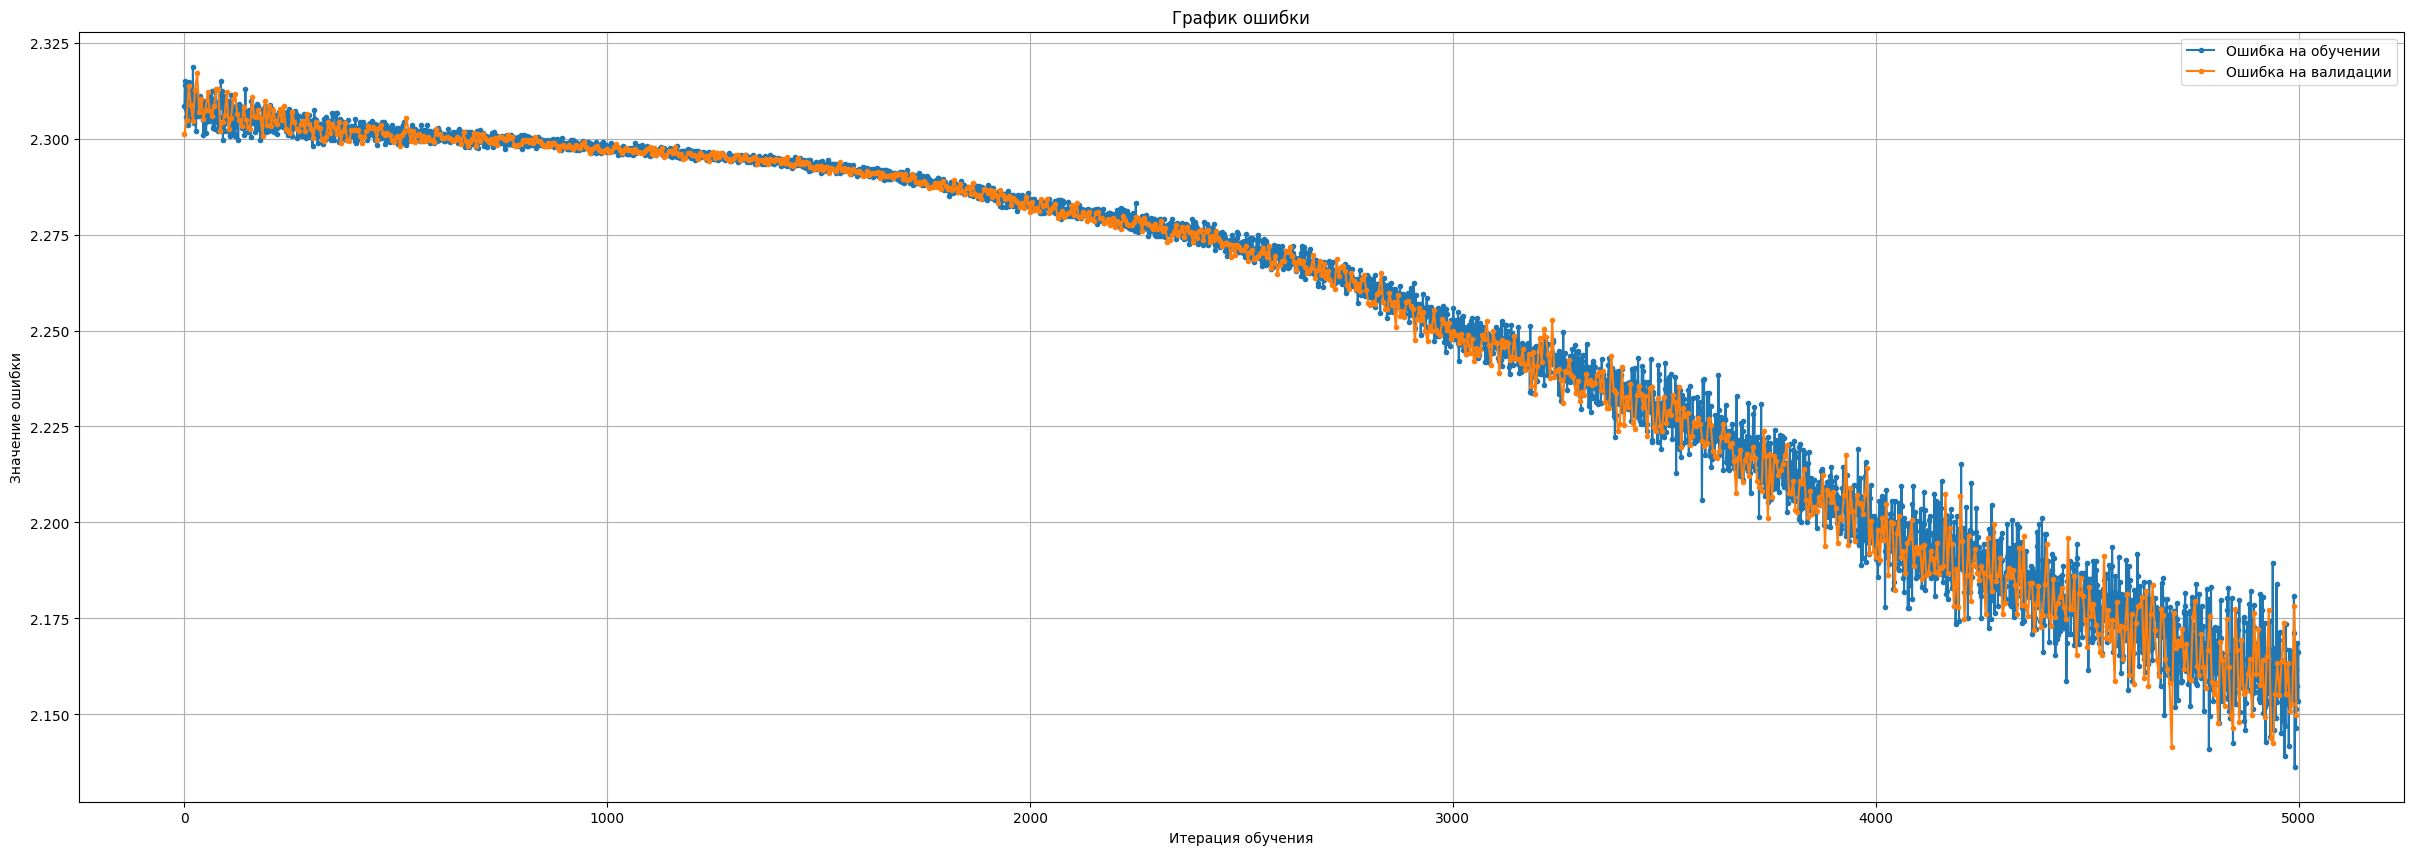

In [ ]:
# Реализуем цикл обучения модели.
# ВАЖНО, что обучение модели с параметрами, приведёнными ниже, работает очень долго.

from IPython.display import clear_output

# Для ускорения обучения используем видеокарту компьютера
#  или виртуальной машины, если есть такая возможность.
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 5000
batch_size = 1000
val_every = 5

model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=torch.nn.ReLU,
    flatten=False,
).to(dtype=x_train.dtype, device=device)  # Важно, чтобы все тензоры были одного типа и на одном устройстве.

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
)

# Шедулер (scheduler) отвечает за изменение величины шага градиентного спуска, который
#  в данном случае мы будем постепенно уменьшать с течением времени.
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.NLLLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()

    # Будем на каждой итерации обучения брать не все 50 000 картинок,
    #  а лишь случайные batch_size из них.
    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])

    pred = model(x_train[batch_pos].to(device))  # Также переносим тензоры на устойство.
    loss = loss_fn(pred, y_train[batch_pos].to(device))

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    # Каждые val_every итераций считаем значение loss на валидационной выборке.
    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_val[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())

    # Каждые 1000 итераций уменьшаем шаг градиентного спуска.
    if epoch % 1000 == 0:
        scheduler.step()

    # Каждые 100 итераций рисуем графики loss.
    if epoch % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

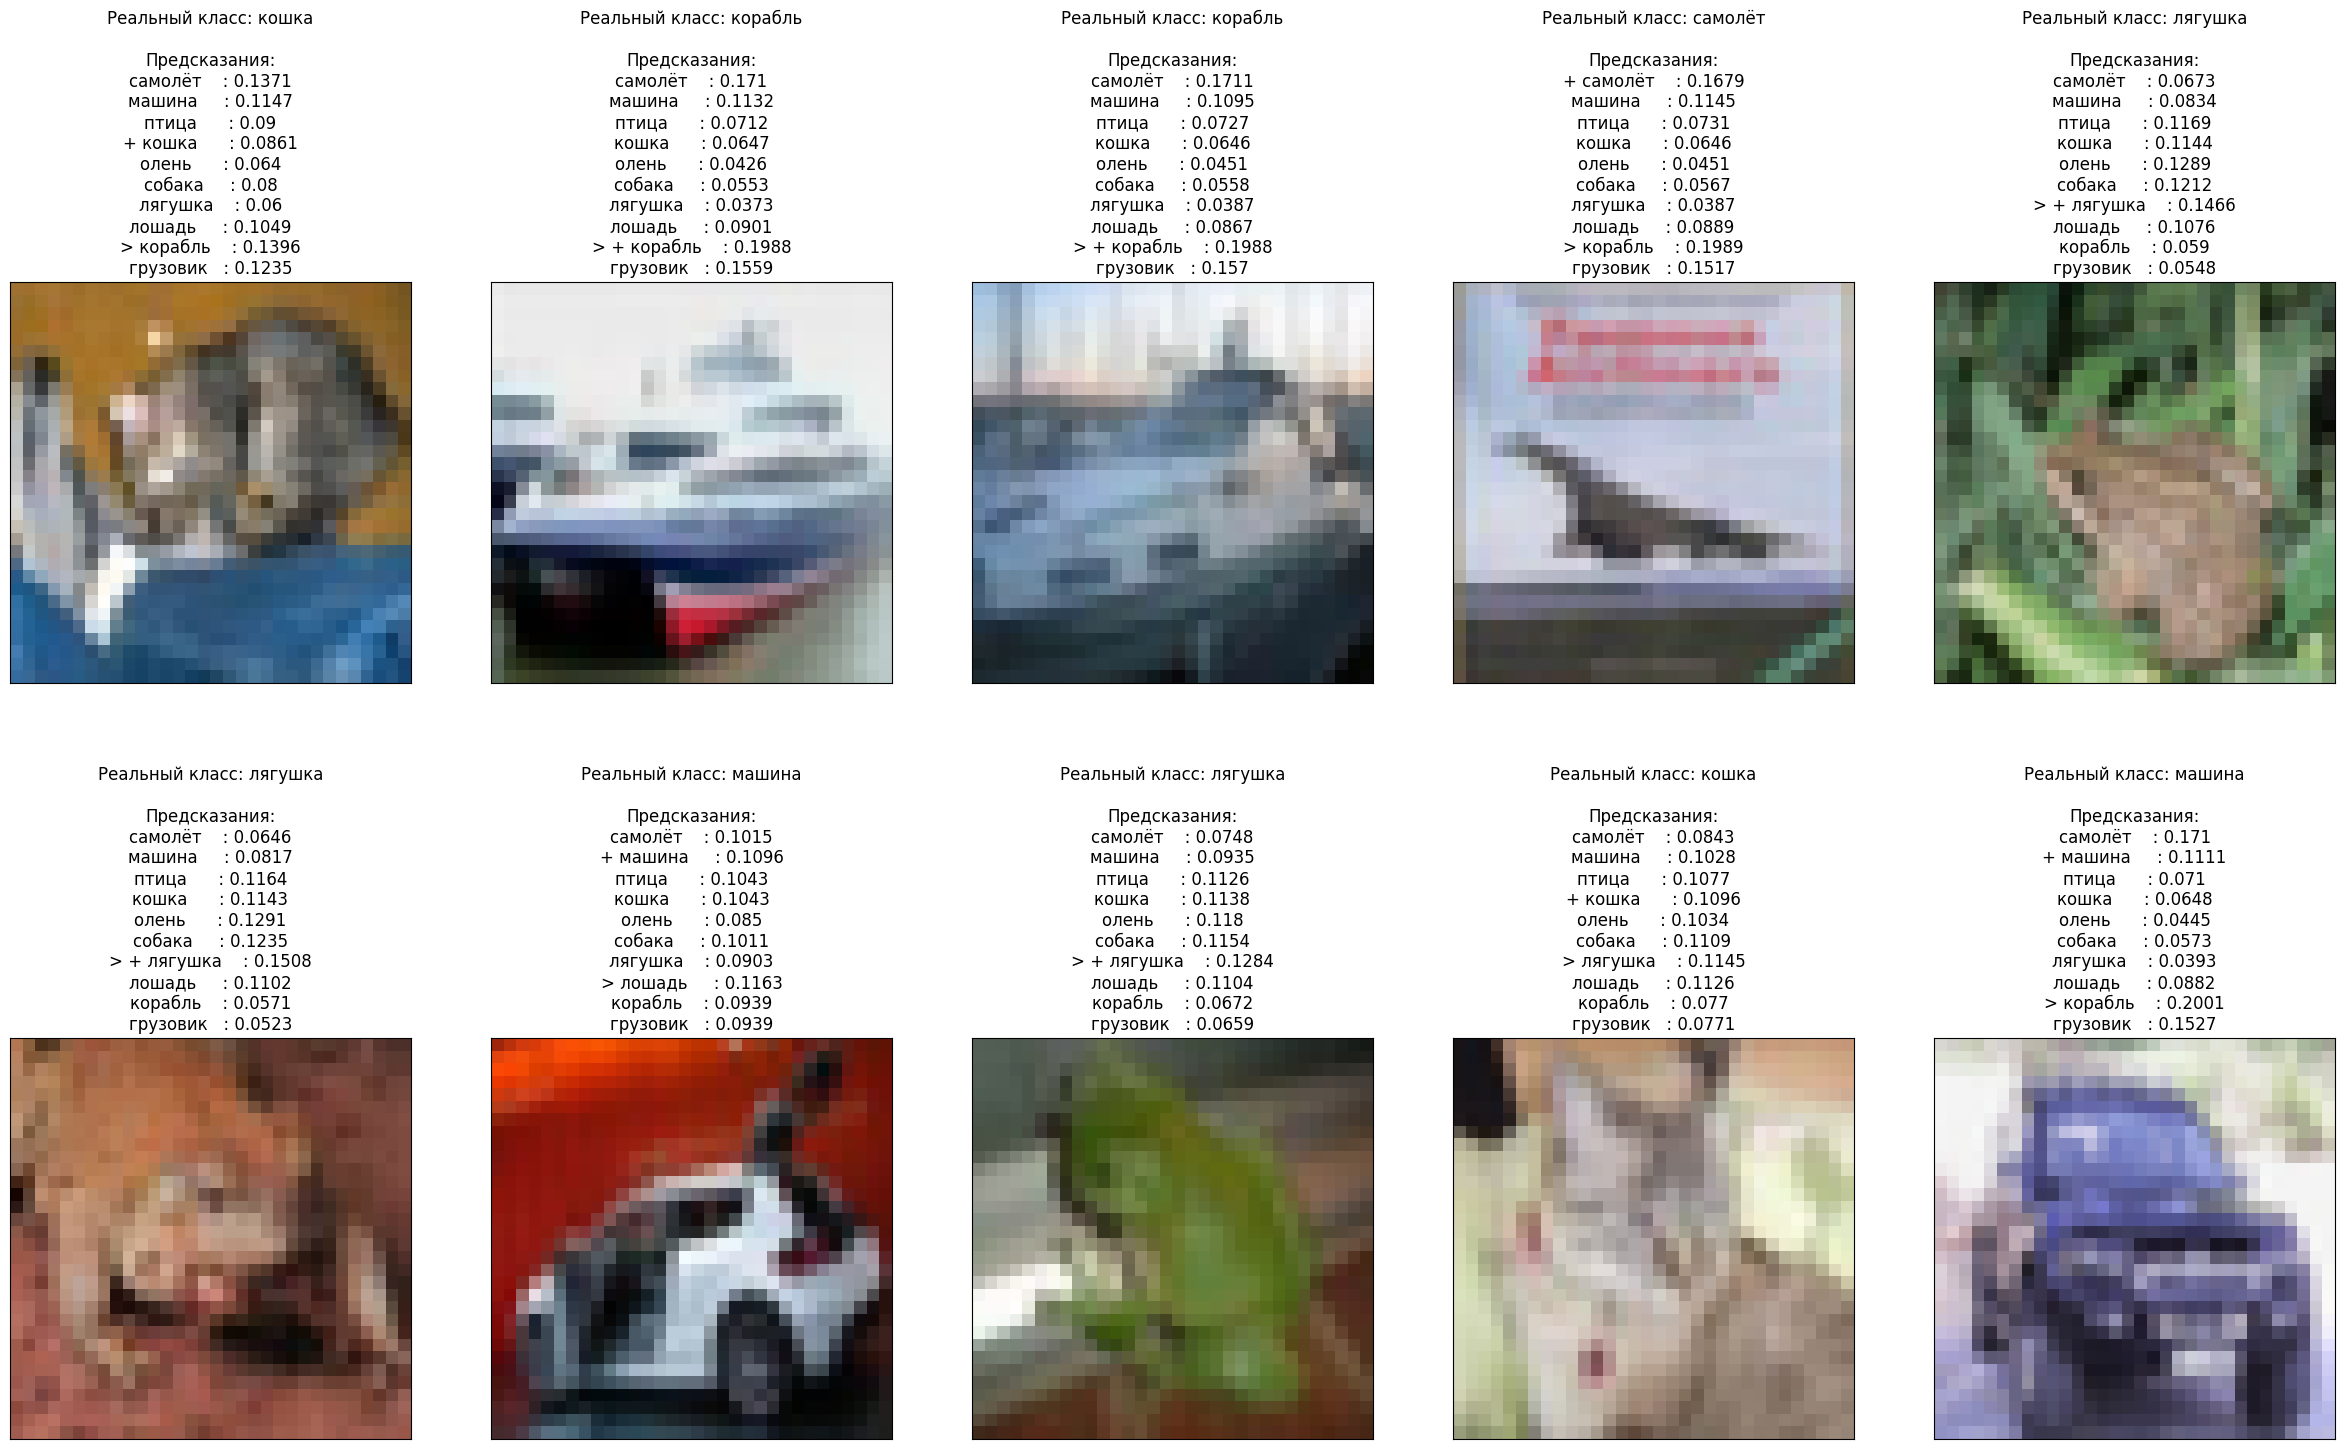

In [ ]:
# Посмотрим на предсказания нашей модели на примерах из валидационной выборки.

classes_ru = [
    "самолёт",
    "машина",
    "птица",
    "кошка",
    "олень",
    "собака",
    "лягушка",
    "лошадь",
    "корабль",
    "грузовик",
]

def show_results(model, h=2, w=5):
    with torch.no_grad():
        batch_probs = model(x_val[:h*w].to(device)).exp()

        fig, ax = plt.subplots(h, w, figsize=(30, 9 * h))
        for i in range(h * w):
            plt.subplot(h, w, i+1)
            plt.imshow(x_val[i])
            title = f'Реальный класс: {classes_ru[y_val[i]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[i] else "+ ",
                    classes_ru[j],
                    round(prob.item(), 4),
                )

            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

show_results(model)

#### Задание.
Примените технологию residual connection для нейросети из задания № 2.

1) Опишите архитектуру нейросети

2) Создайте экземпляр класса ResidualModel

3) Проведите обучение нейронной сети. Сделайте отображение величины ошибки для тренировочной и валидационной выборки нак графике в процесе вычислений (аналогично примеру выше).

4) Отобразите результат классификации с указанием класса-результата и верного ответа для 10 случайных картинок тестовой выборки (аналогично примеру выше).
5) Сравните точность полученной модели с той, что была реализована в задании № 2.
   

In [ ]:
# ваш код здесь

In [2]:
import torch
import random
import numpy as np
import torchvision.datasets
from torchvision import transforms
from collections import OrderedDict
from torchvision import datasets
from torch.utils.data import random_split, Subset

In [10]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ])

In [18]:
full_train_data = datasets.GTSRB('./', split='train', download=True, transform=transform)

subset_size = int(0.1 * len(full_train_data))

# Генерируем случайные индексы для подмножества
indices = np.random.choice(len(full_train_data), size=subset_size, replace=False)

# Создаем подмножество на основе выбранных индексов
subset_train_data = Subset(full_train_data, indices)


val_size = int(0.1 * len(subset_train_data))
train_size = len(subset_train_data) - val_size

# Разделите на тренировочные и валидационные данные
train_data, val_data = random_split(subset_train_data, [train_size, val_size])

# Теперь определим размер тестового множества равным размеру валидационного
test_size = val_size

# Загрузите тестовый набор данных
full_test_data = datasets.GTSRB('./', split='test', download=True, transform=transform)

# Генерируем случайные индексы для тестового множества
test_indices = np.random.choice(len(full_test_data), size=test_size, replace=False)

# Создаем тестовое множество на основе выбранных индексов
test_data = Subset(full_test_data, test_indices)

# Теперь у вас есть train_data, val_data и test_data
print(f'Train data size: {len(train_data)}')
print(f'Validation data size: {len(val_data)}')
print(f'Test data size: {len(test_data)}')

Train data size: 2398
Validation data size: 266
Test data size: 266


In [13]:
#full_test_data = torchvision.datasets.GTSRB('./', split='test', download=True, transform=transform)

In [14]:
#val_size = int(0.5 * len(full_test_data))
#test_size = len(full_test_data) - val_size

In [15]:
#test_data, val_data = random_split(full_test_data, [test_size, val_size])

In [16]:
#train_data = torchvision.datasets.GTSRB('./', split='train', download=True, transform=transform)

In [17]:
#print(f'Train data size: {len(train_data)}')
#print(f'Validation data size: {len(val_data)}')
#print(f'Test data size: {len(test_data)}')

Train data size: 26640
Validation data size: 6315
Test data size: 6315


In [19]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=26640, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=6315, shuffle=True)

In [20]:
X_test, y_test = next(iter(test_dataloader))

In [21]:
X_train, y_train = next(iter(train_dataloader))
print(f"Feature batch shape: {X_train.size()}")
print(f"Labels batch shape: {y_train.size()}")

Feature batch shape: torch.Size([2398, 3, 224, 224])
Labels batch shape: torch.Size([2398])


In [22]:

print(y_train.shape, y_train.min(), y_train.max(), sep="\n")

torch.Size([2398])
tensor(0)
tensor(42)


In [23]:
class ResidualBlock(torch.nn.Module):
    def __init__(
        self,
        input_c,
        output_c,
        kernel_size,
        activation=torch.nn.ReLU,
    ):
        super().__init__()

        self.activation = activation()

        padding_size = kernel_size // 2

        self.conv = torch.nn.Conv2d(
             in_channels=input_c,
             out_channels=output_c,
             kernel_size=kernel_size,
             padding=padding_size,
             padding_mode="zeros",
             stride=1,
             dilation=1,
)

        if input_c != output_c:
            self.correct_channels = torch.nn.Conv2d(
               in_channels=input_c,
               out_channels=output_c,
               kernel_size=1,
)
        else:
            self.correct_channels = torch.nn.Identity()

    def forward(self, x):
        fx = self.conv(x)
        new_x = self.correct_channels(x)
        return fx + new_x

In [24]:
h = torch.rand(2, 3)

print(h, h.max(1), h.max(1).values.shape, h[0, :], h[1, :], sep="\n\n")

tensor([[0.3745, 0.5982, 0.1477],
        [0.7118, 0.8731, 0.8341]])

torch.return_types.max(
values=tensor([0.5982, 0.8731]),
indices=tensor([1, 1]))

torch.Size([2])

tensor([0.3745, 0.5982, 0.1477])

tensor([0.7118, 0.8731, 0.8341])


In [25]:
class ResidualModel(torch.nn.Module):
    def __init__(
        self,
        out_size,                    # Число классов.
        residual_sizes,              # Задаём список троек: количество residual-блоков,
                                     #  число каналов и размер ядра в каждом таком блоке.
        linear_sizes,                # Список размеров линейных слоёв в финальном классификаторе.
        activation = torch.nn.ReLU,  # Какую функцию активации использовать.
        flatten = True,
        img_size = 32,
        current_ch= 3

    ):
        super().__init__()
        self.flatten = flatten

        # Собираем все свёрточные слои в один блок.
        conv_layers = []

        current_c = current_ch
        for group_index, (num_residual, out_channels, kernel_size) in enumerate(residual_sizes):
            for residual_index in range(num_residual):
                conv_layers.append((
                    # Добавляем несколько residual-блоков для каждой группы.
                    f"residual_{group_index}_{residual_index}",
                    ResidualBlock(
                        input_c = current_c if residual_index == 0 else out_channels,
                        output_c = out_channels,
                        kernel_size = kernel_size,
                        activation = activation,
                    ),
                ))
            current_c = out_channels
            if group_index < len(residual_sizes) - 1:
                conv_layers.append((
                    # В конце группы добавляем один pooling-слой,
                    # если это не последняя группа.
                    f"pooling_{group_index}",
                    torch.nn.AvgPool2d(2),
                ))

        self.conv_part = torch.nn.Sequential(OrderedDict(conv_layers))

        # Собираем все линейные слои во второй блок.
        out_c = residual_sizes[-1][1]
        final_size = img_size // 2 ** (len(residual_sizes) - 1)
        clf_in_size = (out_c * final_size**2) if flatten else out_c

        linear_sizes = [clf_in_size, *linear_sizes, out_size]

        clf_layers = []

        for i, (from_size, to_size) in enumerate(zip(linear_sizes[:-1], linear_sizes[1:])):
            clf_layers.append((f"linear_{i}", torch.nn.Linear(from_size, to_size)))
            if i < len(linear_sizes) - 2:
                clf_layers.append((f"act_{i}", activation()))
            else:
                clf_layers.append(("log_softmax", torch.nn.LogSoftmax(-1)))

        self.clf_part = torch.nn.Sequential(OrderedDict(clf_layers))

    def forward(self, x):  # input (bs x h x w x c_in)
        x = x.permute((0, 1, 2, 3))  # (bs x c_in x h x w)

        x = self.conv_part(x)  # bs x c_out x h' x w'

        if self.flatten:
            # Операция Flatten.
            x = x.reshape(x.shape[0], -1)  # bs x (c_out * h' * w')
        else:
            # Операция GlobalMaxPooling.
            x = x.max(-1).values.max(-1).values  # bs x c_out


        x = self.clf_part(x)  # bs x 10

        return x


In [26]:
def print_num_params(model):
    # Считаем общее количество обучаемых весов в модели.
    sum_params_size = 0
    for name, param in model.named_parameters():
        param_size = param.numel()
        print("{:<46} ~ {:<14} ~ {}".format(name, str(list(param.shape)), param_size))
        sum_params_size += param_size
    print(f"Общее число параметров ~ {sum_params_size}")


In [27]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model1 = ResidualModel(
    out_size=43,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3), (2, 32, 3)],
    linear_sizes=[1000],
    activation=torch.nn.LeakyReLU,
    flatten=True,
    img_size=X_test.shape[-1],
    current_ch=X_test.shape[1],

).to(dtype=X_train.dtype, device=device)
model1

ResidualModel(
  (conv_part): Sequential(
    (residual_0_0): ResidualBlock(
      (activation): LeakyReLU(negative_slope=0.01)
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_0_1): ResidualBlock(
      (activation): LeakyReLU(negative_slope=0.01)
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identity()
    )
    (pooling_0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (residual_1_0): ResidualBlock(
      (activation): LeakyReLU(negative_slope=0.01)
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (residual_1_1): ResidualBlock(
      (activation): LeakyReLU(negative_slope=0.01)
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (correct_channels): Identi

In [28]:
print_num_params(model1)

conv_part.residual_0_0.conv.weight             ~ [8, 3, 3, 3]   ~ 216
conv_part.residual_0_0.conv.bias               ~ [8]            ~ 8
conv_part.residual_0_0.correct_channels.weight ~ [8, 3, 1, 1]   ~ 24
conv_part.residual_0_0.correct_channels.bias   ~ [8]            ~ 8
conv_part.residual_0_1.conv.weight             ~ [8, 8, 3, 3]   ~ 576
conv_part.residual_0_1.conv.bias               ~ [8]            ~ 8
conv_part.residual_1_0.conv.weight             ~ [16, 8, 3, 3]  ~ 1152
conv_part.residual_1_0.conv.bias               ~ [16]           ~ 16
conv_part.residual_1_0.correct_channels.weight ~ [16, 8, 1, 1]  ~ 128
conv_part.residual_1_0.correct_channels.bias   ~ [16]           ~ 16
conv_part.residual_1_1.conv.weight             ~ [16, 16, 3, 3] ~ 2304
conv_part.residual_1_1.conv.bias               ~ [16]           ~ 16
conv_part.residual_2_0.conv.weight             ~ [32, 16, 3, 3] ~ 4608
conv_part.residual_2_0.conv.bias               ~ [32]           ~ 32
conv_part.residual_2_0.corre

In [29]:
import matplotlib.pyplot as plt

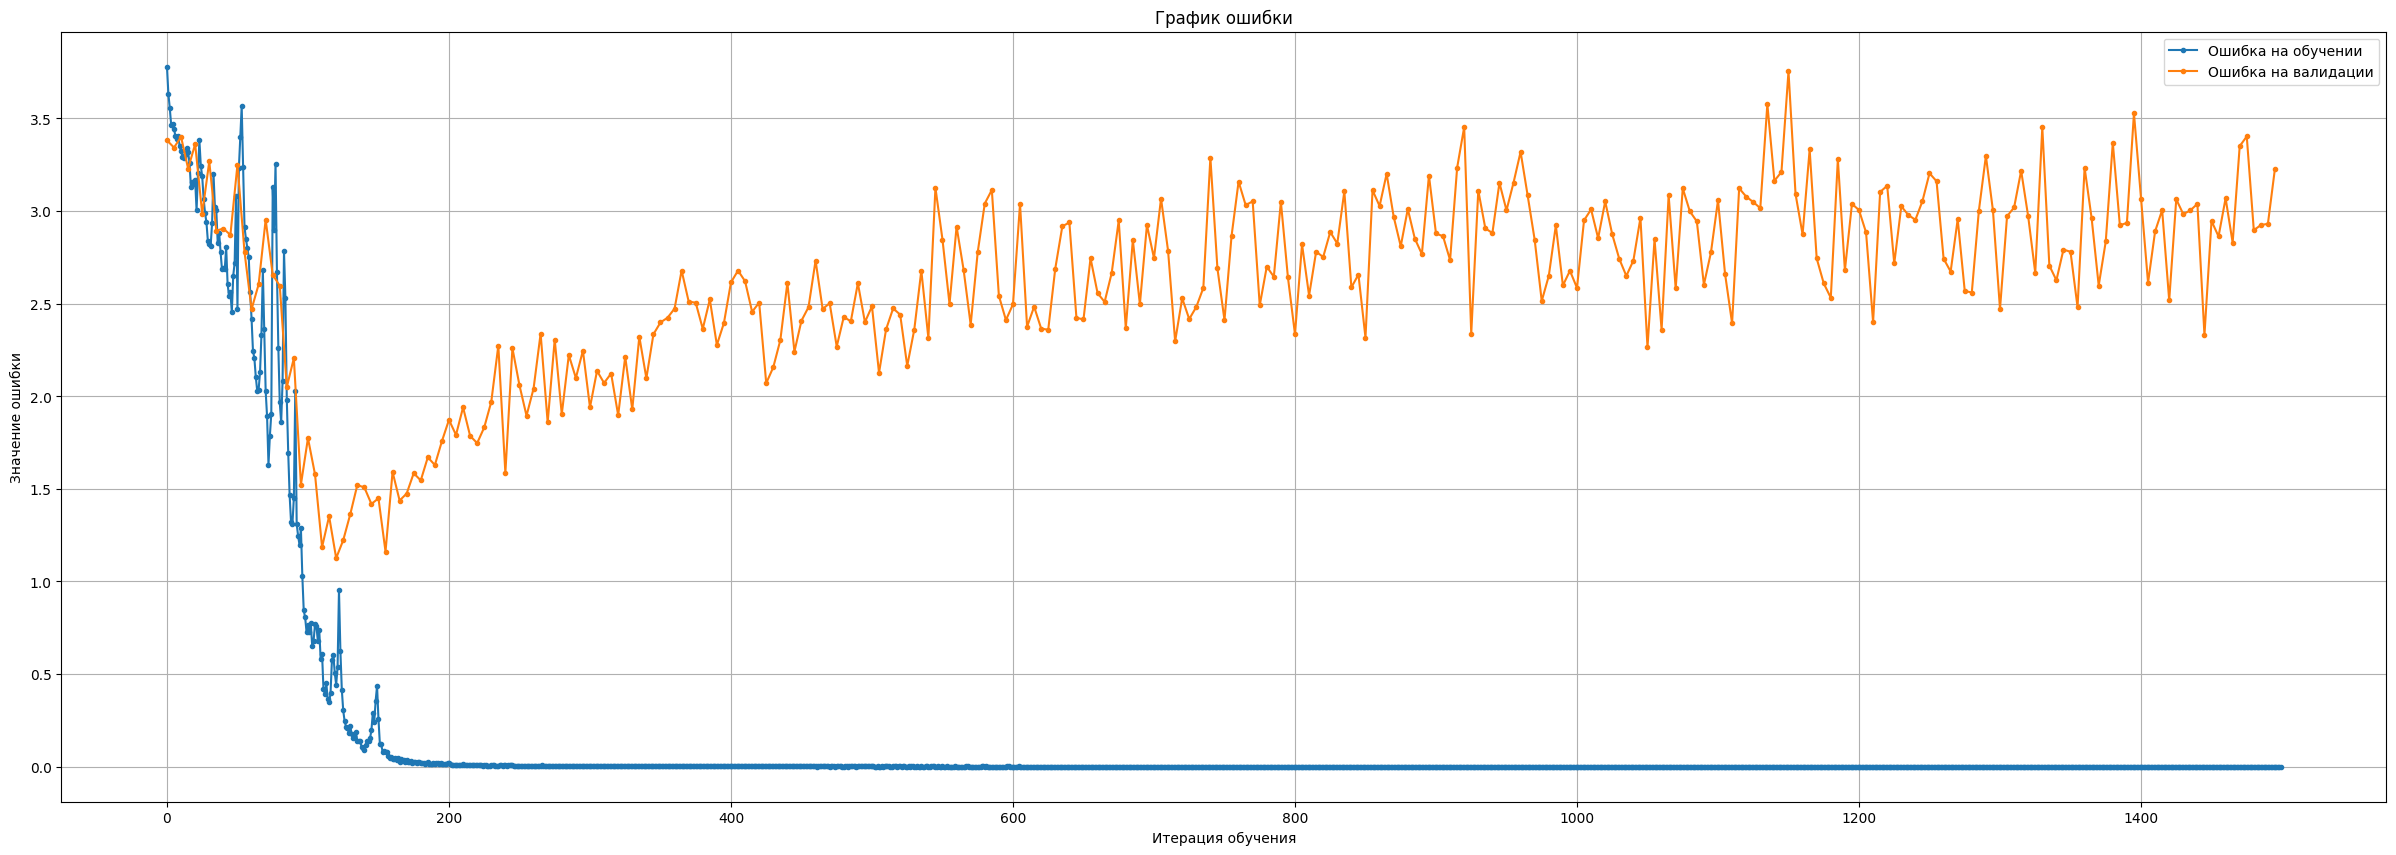

In [30]:
from IPython.display import clear_output

# Для ускорения обучения используем видеокарту компьютера
#  или виртуальной машины, если есть такая возможность.

num_epochs = 1500
batch_size = 1000
val_every = 5

model1.to(dtype=X_train.dtype, device=device)

optimizer = torch.optim.SGD(
    model1.parameters(),
    lr=1e-2,
)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.NLLLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()

    batch_pos = torch.randint(high=X_train.shape[0], size=[batch_size])

    pred = model1(X_train[batch_pos].to(device))
    loss = loss_fn(pred, y_train[batch_pos].to(device))

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=X_test.shape[0], size=[batch_size])
            val_pred = model1(X_test[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_test[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())

    if epoch % 1000 == 0:
        scheduler.step()

    if epoch % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

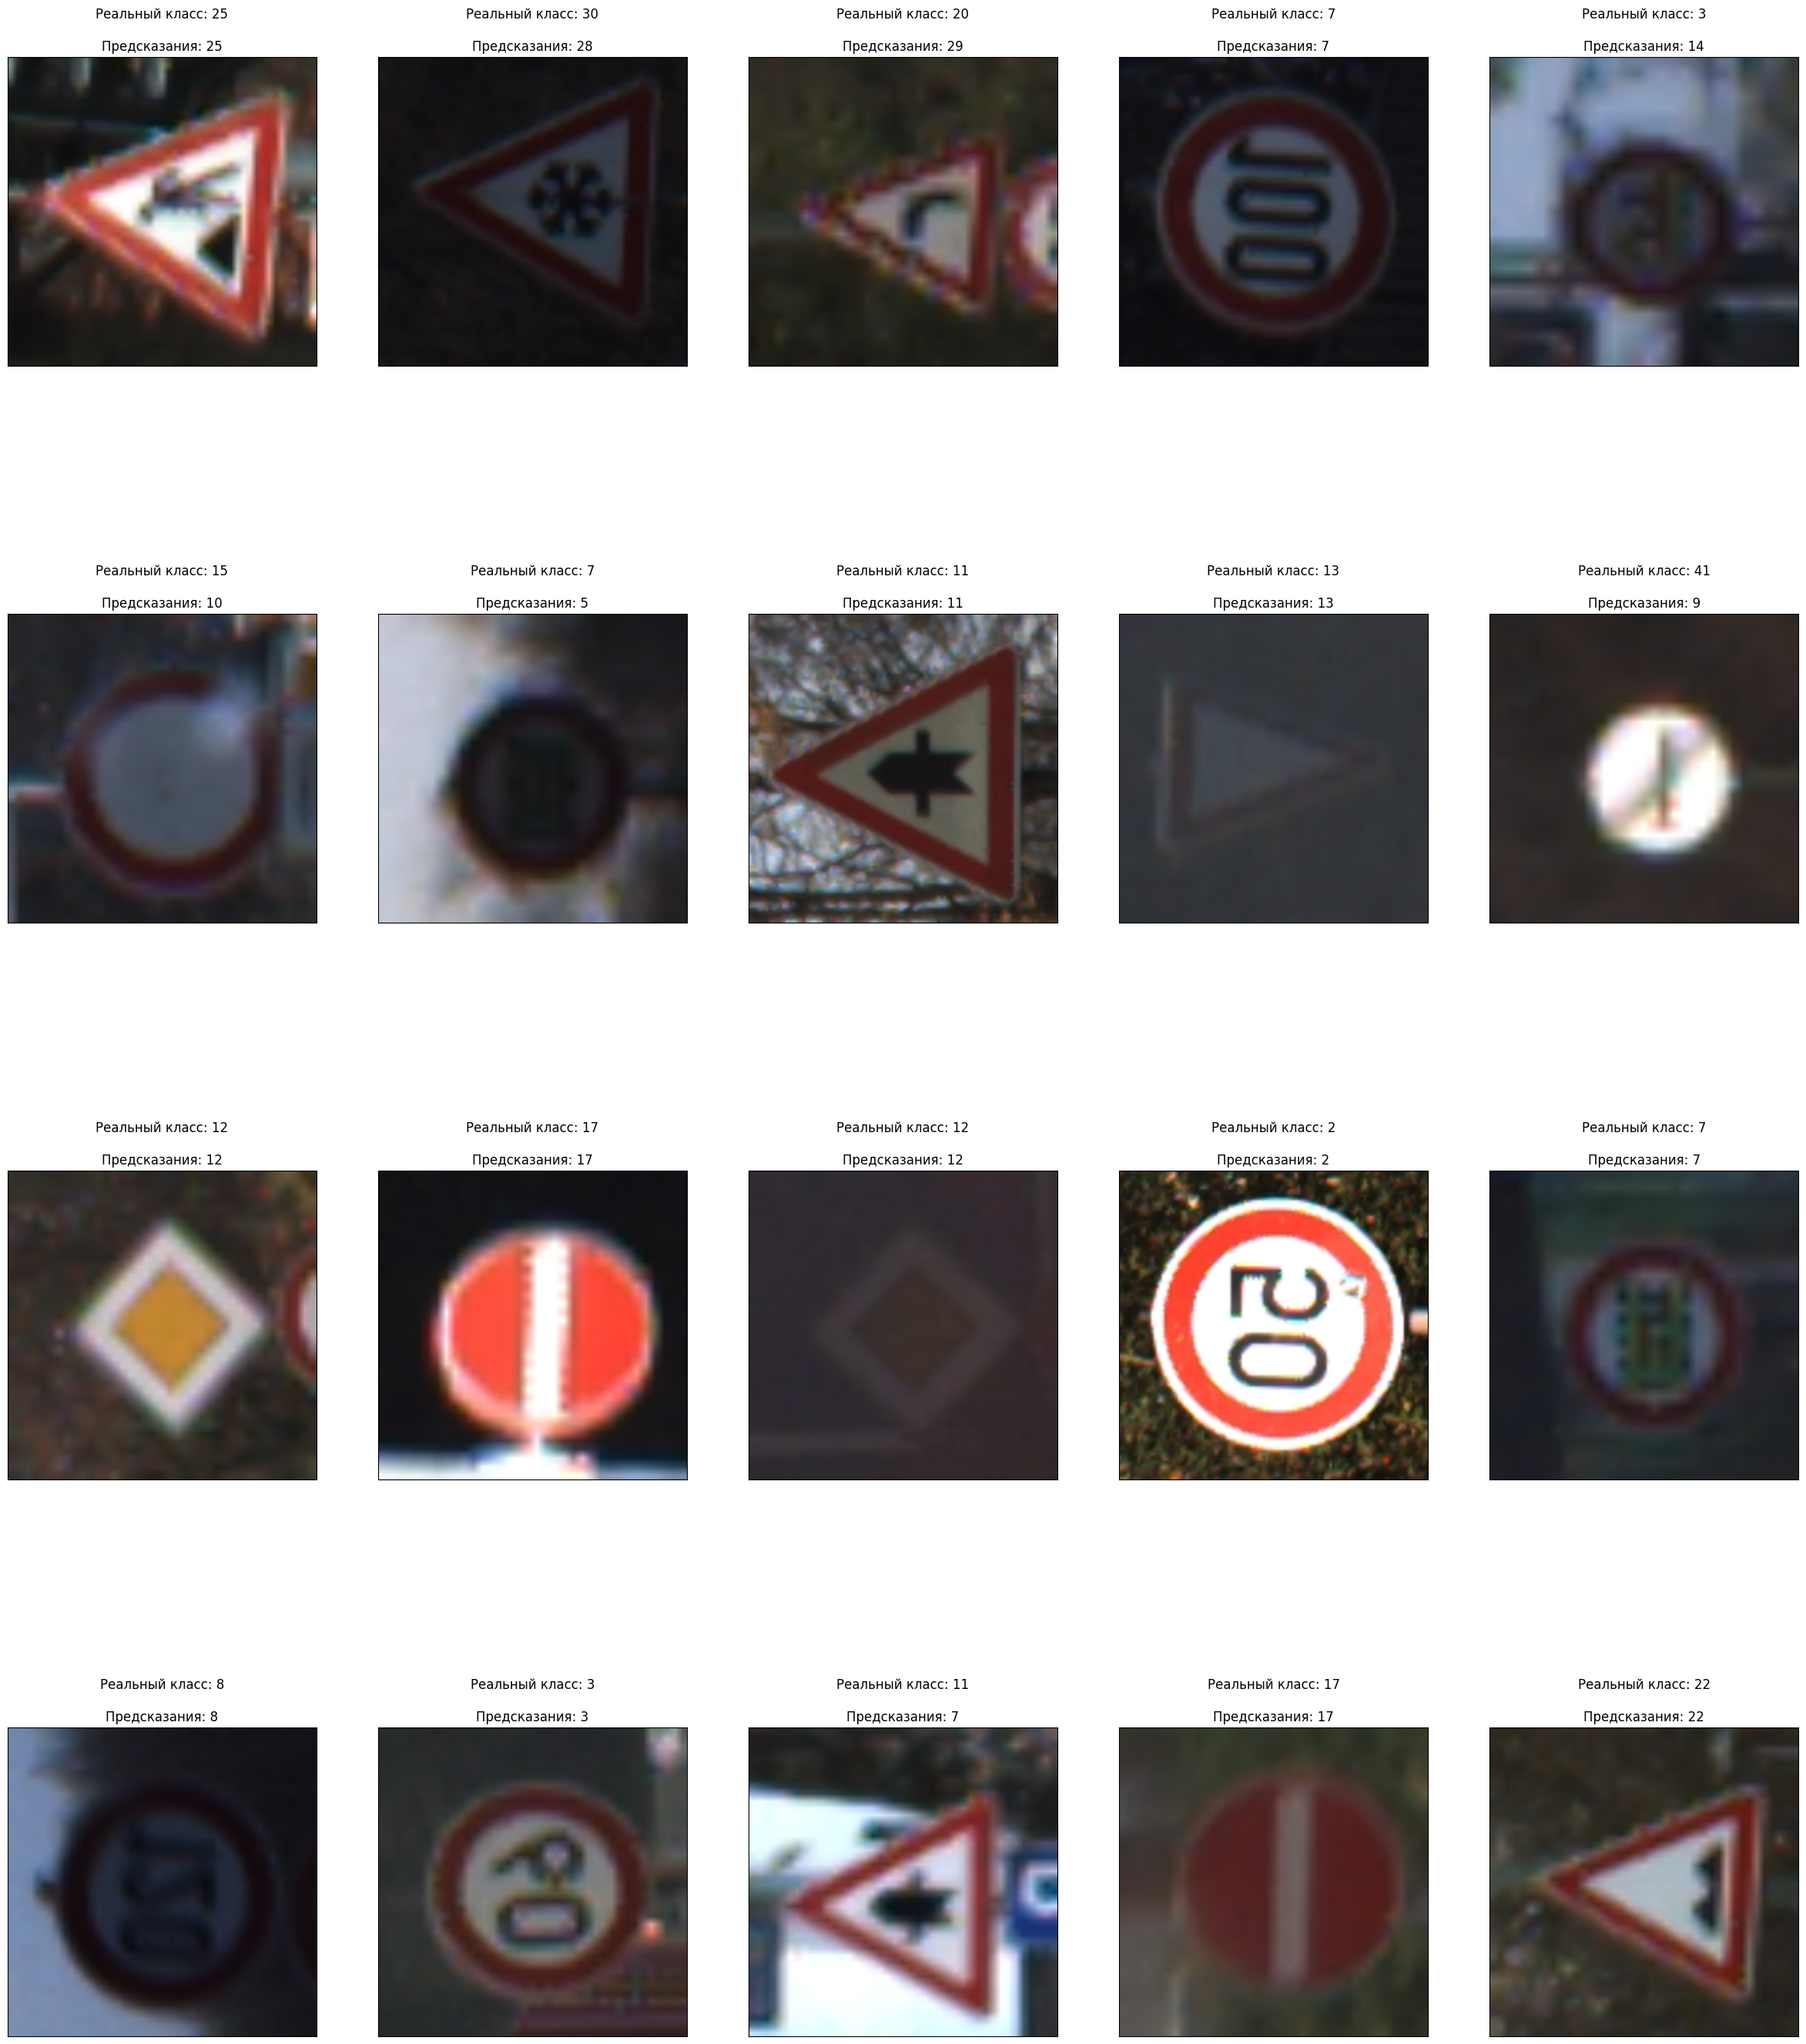

In [31]:
def show_results(model, h=4, w=5):
    with torch.no_grad():
        batch_probs = model(X_test[:h*w].to(device)).exp()

        fig, ax = plt.subplots(h, w, figsize=(30, 9 * h))
        for i in range(h * w):
            plt.subplot(h, w, i+1)
            plt.imshow(X_test[i].permute((2,1,0)))
            title = f'Реальный класс: {y_test[i]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            title += f' {y_pred.data}'

            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

show_results(model1)

